The exercises are prepared by Elena Tiukhova, a PhD researcher at KU Leuven university. For questions/suggestions for improvement, please contact elena.tiukhova@kuleuven.be

Dataset sources:

https://www.kaggle.com/code/renatevankempen/predicting-clv/data

https://www.kaggle.com/datasets/shrutimechlearn/customer-data

https://www.kaggle.com/code/hendraherviawan/customer-segmentation-using-rfm-analysis-r/data

In [ ]:
import pandas as pd
from scipy.stats import iqr
import numpy as np
import matplotlib.pyplot as plt
from numpy import arange

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sklearn.utils.validation
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn import metrics

import statsmodels.api as sm
from scipy import stats

# Data Preprocessing

In [ ]:
data = pd.read_excel("data.xlsx")

In [ ]:
data = data.set_index('CustomerID')

First, we should check the dataset for missing values.

In [ ]:
data.isnull().sum()

Gender              20
Income               5
Marital Status      17
CLV                  0
Age                 13
Frequency           14
Monetary            14
Recency             18
EmploymentStatus    19
dtype: int64

We can see that all the columns except CLV have missing values. For the categorical variables (Gender, Employment status and Marital status), we can replace missing values by the mode. For the continuous variables (Age, Income and RFM variables), we can replace missing values by the median. 

In [ ]:
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data['EmploymentStatus'] = data['EmploymentStatus'].fillna(data['EmploymentStatus'].mode()[0])
data['Marital Status'] = data['Marital Status'].fillna(data['Marital Status'].mode()[0])

In [ ]:
data['Frequency'] = data['Frequency'].fillna(round(data['Frequency'].median(),0))
data['Recency'] = data['Recency'].fillna(round(data['Recency'].median(),0))
data['Monetary'] = data['Monetary'].fillna(data['Monetary'].median())
data['Age'] = data['Age'].fillna(round(data['Age'].median(),0))
data['Income'] = data['Income'].fillna(round(data['Income'].median(),0))

In [ ]:
data.isnull().sum()

Gender              0
Income              0
Marital Status      0
CLV                 0
Age                 0
Frequency           0
Monetary            0
Recency             0
EmploymentStatus    0
dtype: int64

Next, we can check the basic decriptive statistics of the dataset.

In [ ]:
data.describe()

Income          CLV          Age   Frequency     Monetary  \
count    500.000000   500.000000   500.000000  500.000000   500.000000   
mean   35799.834000  4246.119065    75.196000   66.588000   772.119641   
std    29223.588324  2610.448738   446.072899   27.475736   283.006282   
min        0.000000     2.224768  -500.000000    5.000000    40.000000   
25%        0.000000  2369.295653    38.000000   45.000000   570.837219   
50%    32471.000000  4117.058275    56.000000   64.000000   747.262313   
75%    58844.000000  5927.234166    76.000000   86.000000   977.726048   
max    99845.000000  9951.707743  9999.000000  193.000000  1478.831086   

          Recency  
count  500.000000  
mean    63.844000  
std     25.926048  
min      5.000000  
25%     48.000000  
50%     65.000000  
75%     82.000000  
max    111.000000

From the desriptive statistics, we can see that there are irrelevant age values (min of -500 and max of 9999). These values are obvious outliers. The negative age values are not realistic and we can impute them with, for instance, the minimal value of the age variable. For the positive values of the Age variable, we can detect outliers by employing robust z-scores. The observations that have robust z-scores for the Age variable greater than 3 can be considered outliers. We can replace outliers with the robust z-score higher than 3 with the value of median + 3*IQR.

In [ ]:
data['Age: robust z-score'] = (data['Age'] - data['Age'].median())/iqr(data['Age'])
data['Age'] = np.where((data['Age'] < 0),data[data['Age'] > 0]['Age'].min(),data['Age'])
data['Age'] = np.where((data['Age: robust z-score'] > 3),data['Age'].median() + 3*iqr(data['Age']),data['Age'])

We can also check other variables for the outliers using the same approach of robust z-scores. From the descriptive statistics, we can see that these columns do not have negative values, and any positive value is relevant except of extremely high values. These extreme cases can be detected by looking at robust z-scores higher than 3 and replaced with the value of median + 3*IQR.

In [ ]:
data['Income: robust z-score'] = (data['Income'] - data['Income'].median())/iqr(data['Income'])
data['Income'] = np.where((data['Income: robust z-score'] > 3),
                                 data['Income'].median() + 3*iqr(data['Income']),data['Income'])

data['Monetary: robust z-score'] = (data['Monetary'] - data['Monetary'].median())/iqr(data['Monetary'])
data['Monetary'] = np.where((data['Monetary: robust z-score'] > 3),
                                 data['Monetary'].median() + 3*iqr(data['Monetary']),data['Monetary'])

data['Frequency: robust z-score'] = (data['Frequency'] - data['Frequency'].median())/iqr(data['Frequency'])
data['Frequency'] = np.where((data['Frequency: robust z-score'] > 3),
                                 round(data['Frequency'].median() + 3*iqr(data['Frequency']),0),data['Frequency'])

data['Recency: robust z-score'] = (data['Recency'] - data['Recency'].median())/iqr(data['Recency'])
data['Recency'] = np.where((data['Recency: robust z-score'] > 3),
                                 round(data['Recency'].median() + 3*iqr(data['Recency']),0),data['Recency'])

data['CLV: robust z-score'] = (data['CLV'] - data['CLV'].median())/iqr(data['CLV'])
data['CLV'] = np.where((data['CLV: robust z-score'] > 3),
                                 data['CLV'].median() + 3*iqr(data['CLV']),data['CLV'])

In [ ]:
data = data.drop(columns = ['Age: robust z-score',
       'Income: robust z-score', 'Monetary: robust z-score',
       'Frequency: robust z-score', 'Recency: robust z-score',
       'CLV: robust z-score'])

# Analytical step

In [ ]:
feature_names = ['Income', 'Frequency', 'Monetary', 'Recency', 'Age', 'Male',
       'Employed', 'Medical Leave', 'Retired', 'Unemployed', 'Married',
       'Single']
y = ['CLV']

In order to work with the categorical variables in regression models (linear, ridge and LASSO regression), we need to create dummy variables that represent N categories with N-1 binary variables. We create dummy variables for the Gender, Employment status and Marital status variables.

In [ ]:
data_backup = data.copy()

In [ ]:
encoder = OneHotEncoder(drop='first', sparse=False)

onehot_gender = encoder.fit_transform(np.array(data['Gender']).reshape(-1, 1))
data = pd.concat([data, pd.DataFrame(onehot_gender, columns = ['Male'], index = data.index)], axis = 1)

onehot_employment_status = encoder.fit_transform(np.array(data['EmploymentStatus']).reshape(-1, 1))
data = pd.concat([data, pd.DataFrame(onehot_employment_status, columns = ['Employed', 
                                                  'Medical Leave', 'Retired', 'Unemployed'], index = data.index)],
                 axis = 1)

onehot_marital_status = encoder.fit_transform(np.array(data['Marital Status']).reshape(-1, 1))
data = pd.concat([data, pd.DataFrame(onehot_marital_status, columns = ['Married','Single'], index = data.index)], axis = 1)

data = data.drop(columns = ['Gender','EmploymentStatus','Marital Status'])

## Linear regression

First, we need to split our data into train and test sets - 20% test and 80% train data. Then, we can train a linear regression model using the train set and measure its performance on the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data[y], test_size=0.2, random_state=42)

In [ ]:
reg = LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

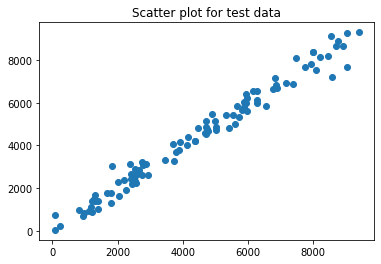

In [ ]:
plt.scatter(y_test, y_pred)
plt.title("Scatter plot for test data")
plt.show()

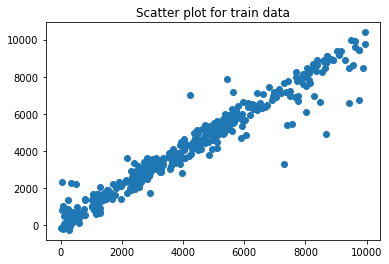

In [ ]:
plt.scatter(y_train, y_pred_train)
plt.title("Scatter plot for train data")
plt.show()

In [ ]:
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
mse = mean_squared_error(y_train, y_pred_train, squared=True)
mad = mean_absolute_error(y_train, y_pred_train)
print('Performance on train data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on train data:
The r2 is:  0.9457947723859531
The rmse is:  611.9807624488204
The mse is:  374520.45360743953
The mad is:  376.49873476128283


In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)
mad = mean_absolute_error(y_test, y_pred)
print('Performance on test data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on test data:
The r2 is:  0.9775811206126566
The rmse is:  375.9223143704737
The mse is:  141317.5864416533
The mad is:  280.0058329136735


We can also calculate the p-value for the coefficients of the linear regression to check for their significance.

In [ ]:
params = np.append(reg.intercept_,reg.coef_)
predictions = reg.predict(X_train)
new_X = np.append(np.ones((len(X_train),1)), X_train, axis=1)
M_S_E = sum(((y_train-predictions)**2/(len(new_X)-len(new_X[0])))['CLV'])
v_b = M_S_E*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
s_b = np.sqrt(v_b)
t_b = params/ s_b
p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
p_val = np.round(p_val,3)

The coefficient of the regression model along with their p-values are depicted below. First of all, we can see that RFM variables along with the Gender variable (dummy variable Male) and Marital Status variable (dummy variables Married and Single) are significant at 5% significance level. We can see that higher Frequency and Monetary variables imply higher CLV while higher Recency values imply lower CLV. Male customers tend to have lower CLV than female customers while being married or single increases CLV compared to being divorced.

In [ ]:
cdf = pd.concat([pd.DataFrame(np.concatenate((['Intercept'], feature_names))),
                 pd.DataFrame(np.transpose(np.concatenate((reg.intercept_, reg.coef_[0])))),pd.DataFrame(p_val)],  axis = 1)
cdf.columns = ['Variable','Coef.', 'p-value']
cdf

Variable        Coef.  p-value
0       Intercept  4533.157337    0.000
1          Income    -0.000339    0.761
2       Frequency    22.064956    0.000
3        Monetary     2.157039    0.000
4         Recency   -56.183490    0.000
5             Age     1.840324    0.165
6            Male  -133.612604    0.035
7        Employed   -13.792239    0.894
8   Medical Leave   -96.832074    0.294
9         Retired   -61.445407    0.544
10     Unemployed   -86.403784    0.399
11        Married   204.408163    0.031
12         Single   239.067985    0.023

Along with the scikit-learn library, there are other libraries that can be used to build a linear regression model. We can see that the resulting coefficients are the same as in the scikit-learn implementation.

In [ ]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CLV   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     562.7
Date:                Thu, 09 Jun 2022   Prob (F-statistic):          2.01e-236
Time:                        15:49:40   Log-Likelihood:                -3134.3
No. Observations:                 400   AIC:                             6295.
Df Residuals:                     387   BIC:                             6346.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4533.1573    367.081     12.349

## Ridge regression

First, we need to split our data into train and test sets - 20% test and 80% train data. Then, we can train a ridge regression model using the train set and measure its performance on the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data[y], test_size=0.2, random_state=1)

We will build a ridge regression with built-in cross-validation. We will perform a repeated K-fold cross-validation with K = 10 and number of times cross-validator needs to be repeated set to 3. We will use a negative mean absolute error as a metric to apply to the estimators evaluated.

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=arange(0, 10, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X_train, y_train)
print('alpha: %f' % model.alpha_)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

alpha: 9.990000


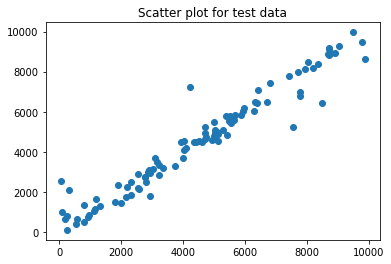

In [ ]:
plt.scatter(y_test, y_pred)
plt.title("Scatter plot for test data")
plt.show()

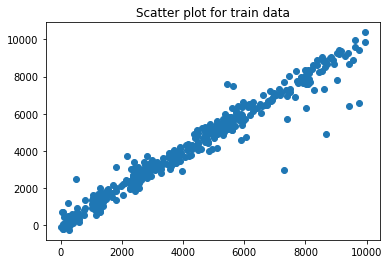

In [ ]:
plt.scatter(y_train, y_pred_train)
plt.title("Scatter plot for train data")
plt.show()

In [ ]:
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
mse = mean_squared_error(y_train, y_pred_train, squared=True)
mad = mean_absolute_error(y_train, y_pred_train)
print('Performance on train data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on train data:
The r2 is:  0.9546892111163565
The rmse is:  552.8992974286415
The mse is:  305697.63309708535
The mad is:  329.0382132066094


In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)
mad = mean_absolute_error(y_test, y_pred)
print('Performance on test data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on test data:
The r2 is:  0.9390849743783293
The rmse is:  649.2789209909758
The mse is:  421563.11724320584
The mad is:  394.8287679522435


We can also calculate the p-value for the coefficients of the linear regression to check for their significance.

In [ ]:
params = np.append(model.intercept_,model.coef_)
predictions = model.predict(X_train)
new_X = np.append(np.ones((len(X_train),1)), X_train, axis=1)
M_S_E = sum(((y_train-predictions)**2/(len(new_X)-len(new_X[0])))['CLV'])
v_b = M_S_E*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
s_b = np.sqrt(v_b)
t_b = params/ s_b
p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
p_val = np.round(p_val,3)

The coefficient of the regression model along with their p-values are depicted below. The results are similar to the linear regression model but we see that less coefficients are significant in this model as ridge regression shrinks coefficients due to L2 regularization. RFM variables along with the Gender variable (dummy variable Male), Marital Status variable (only dummy variable Single) and Age variable are significant at 10% significance level. We can see that higher Frequency and Monetary variables imply higher CLV while higher Recency values imply lower CLV. Male customers tend to have lower CLV than female customers while being single increases CLV compared to being divorced. Higher age also implies higher CLV values.

In [ ]:
cdf = pd.concat([pd.DataFrame(np.concatenate((['Intercept'], feature_names))),
                 pd.DataFrame(np.transpose(np.concatenate((model.intercept_, model.coef_[0])))),pd.DataFrame(p_val)],  axis = 1)
cdf.columns = ['Variable','Coef.', 'p-value']
cdf

Variable        Coef.  p-value
0       Intercept  5180.555994    0.000
1          Income     0.000389    0.701
2       Frequency    19.426105    0.000
3        Monetary     1.996917    0.000
4         Recency   -60.689593    0.000
5             Age     1.950192    0.098
6            Male  -185.282914    0.001
7        Employed    14.548323    0.874
8   Medical Leave   -65.120372    0.445
9         Retired   -90.020140    0.332
10     Unemployed   -83.051990    0.360
11        Married   122.369360    0.154
12         Single   180.925201    0.062

## LASSO regression

First, we need to split our data into train and test sets - 20% test and 80% train data. Then, we can train a LASSO regression model using the train set and measure its performance on the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data[y], test_size=0.2, random_state=1)

We will build a Lasso linear model with iterative fitting along a regularization path. The best model is selected by a repeated (3 times) 10-fold cross-validation.

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LassoCV(cv=cv, random_state=0)
model.fit(X_train, y_train['CLV'])
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

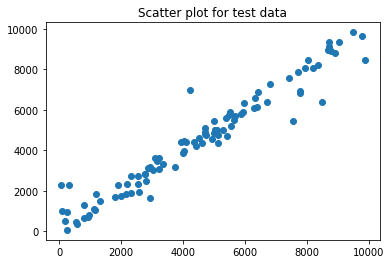

In [ ]:
plt.scatter(y_test, y_pred)
plt.title("Scatter plot for test data")
plt.show()

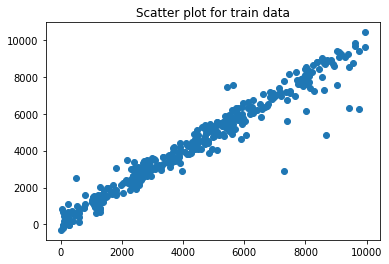

In [ ]:
plt.scatter(y_train, y_pred_train)
plt.title("Scatter plot for train data")
plt.show()

In [ ]:
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
mse = mean_squared_error(y_train, y_pred_train, squared=True)
mad = mean_absolute_error(y_train, y_pred_train)
print('Performance on train data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on train data:
The r2 is:  0.9515426760942622
The rmse is:  571.7747062112852
The mse is:  326926.31466300157
The mad is:  349.19148691308


In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)
mad = mean_absolute_error(y_test, y_pred)
print('Performance on test data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on test data:
The r2 is:  0.9418233355906466
The rmse is:  634.517342391538
The mse is:  402612.25779562024
The mad is:  399.9635098453889


We can also calculate the p-value for the coefficients of the linear regression to check for their significance.

In [ ]:
params = np.append(model.intercept_,model.coef_)
predictions = model.predict(X_train)
new_X = np.append(np.ones((len(X_train),1)), X_train, axis=1)
M_S_E = sum(((y_train['CLV']-predictions)**2/(len(new_X)-len(new_X[0]))))
v_b = M_S_E*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
s_b = np.sqrt(v_b)
t_b = params/ s_b
p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
p_val = np.round(p_val,3)

The coefficient of the regression model along with their p-values are depicted below. We can see that Lasso regression tends to shrink coefficients to absolute zero as compared to Ridge which never sets the value of coefficient to absolute zero. Along with shrinkage, Lasso regression performs variable selection. Only RFM variables are significant in this model. We can see that higher Frequency and Monetary variables imply higher CLV while higher Recency values imply lower CLV.

In [ ]:
cdf = pd.concat([pd.DataFrame(np.concatenate((['Intercept'], feature_names))),
                 pd.DataFrame(np.transpose(np.concatenate(([model.intercept_], model.coef_)))),pd.DataFrame(p_val)],  axis = 1)
cdf.columns = ['Variable','Coef.', 'p-value']
cdf

Variable        Coef.  p-value
0       Intercept  5018.510704    0.000
1          Income    -0.000119    0.910
2       Frequency    18.071430    0.000
3        Monetary     2.260117    0.000
4         Recency   -58.562491    0.000
5             Age     0.533535    0.661
6            Male    -0.000000    1.000
7        Employed     0.000000    1.000
8   Medical Leave    -0.000000    1.000
9         Retired    -0.000000    1.000
10     Unemployed    -0.000000    1.000
11        Married     0.000000    1.000
12         Single     0.000000    1.000

## Regression tree

To handle categorical features in decision trees, we can one-hot encode them by one-hot encoding them that creates a new set of dummy (binary) variables that is equal to the number of categories in the variable. As we do not have many categories in each variable, the effect of one-hot encoding on the decision tree performance is minimal.

In [ ]:
data = data_backup.copy()

In [ ]:
encoder = OneHotEncoder(sparse=False)

onehot_gender = encoder.fit_transform(np.array(data['Gender']).reshape(-1, 1))
data = pd.concat([data, pd.DataFrame(onehot_gender, columns = ['Male', 'Female'], index = data.index)], axis = 1)

onehot_employment_status = encoder.fit_transform(np.array(data['EmploymentStatus']).reshape(-1, 1))
data = pd.concat([data, pd.DataFrame(onehot_employment_status, columns = ['Employed', 
                                                  'Medical Leave', 'Retired', 'Unemployed', 'Disabled'], index = data.index)],
                 axis = 1)

onehot_marital_status = encoder.fit_transform(np.array(data['Marital Status']).reshape(-1, 1))
data = pd.concat([data, pd.DataFrame(onehot_marital_status, columns = ['Married','Single', 'Divorced'], index = data.index)], axis = 1)

data = data.drop(columns = ['Gender','EmploymentStatus','Marital Status'])

In [ ]:
feature_names = ['Income', 'Age', 'Frequency', 'Monetary', 'Recency', 'Male',
       'Female', 'Employed', 'Medical Leave', 'Retired', 'Unemployed',
       'Disabled', 'Married', 'Single', 'Divorced']
y = ['CLV']

First, we need to split our data into train and test sets - 10% test and 90% train data. Then, we can build a regression decision tree model (as the dependent CLV variable is continuous) using the train set (we will use it for grid search cross-validation) and measure its performance on the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data[y], test_size=0.1, random_state=42)

We will use a grid search cross-validation to search for a best depth of the tree. We use train data for our cross-validation that the GridSearchCV will subsequently split into Train and CV sets.

In [ ]:
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.946217172275432 {'max_depth': 17}


We can see that the best depth of the tree according to a grid search is 17.

In [ ]:
y_pred = tree_model.predict(X_test)
y_pred_train = tree_model.predict(X_train)

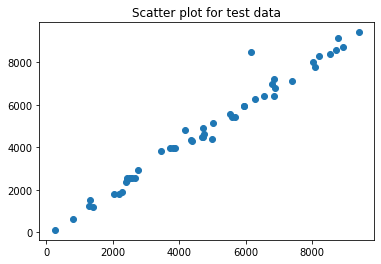

In [ ]:
plt.scatter(y_test, y_pred)
plt.title("Scatter plot for test data")
plt.show()

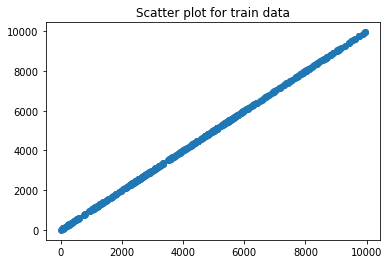

In [ ]:
plt.scatter(y_train, y_pred_train)
plt.title("Scatter plot for train data")
plt.show()

In [ ]:
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
mse = mean_squared_error(y_train, y_pred_train, squared=True)
mad = mean_absolute_error(y_train, y_pred_train)
print('Performance on train data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on train data:
The r2 is:  0.9999996541744356
The rmse is:  1.5416596913901848
The mse is:  2.37671460405728
The mad is:  0.138909783333334


In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)
mad = mean_absolute_error(y_test, y_pred)
print('Performance on test data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on test data:
The r2 is:  0.9722328121873353
The rmse is:  402.20810335156295
The mse is:  161771.35840166156
The mad is:  224.11843655999996


We can visualize the tree that we built.

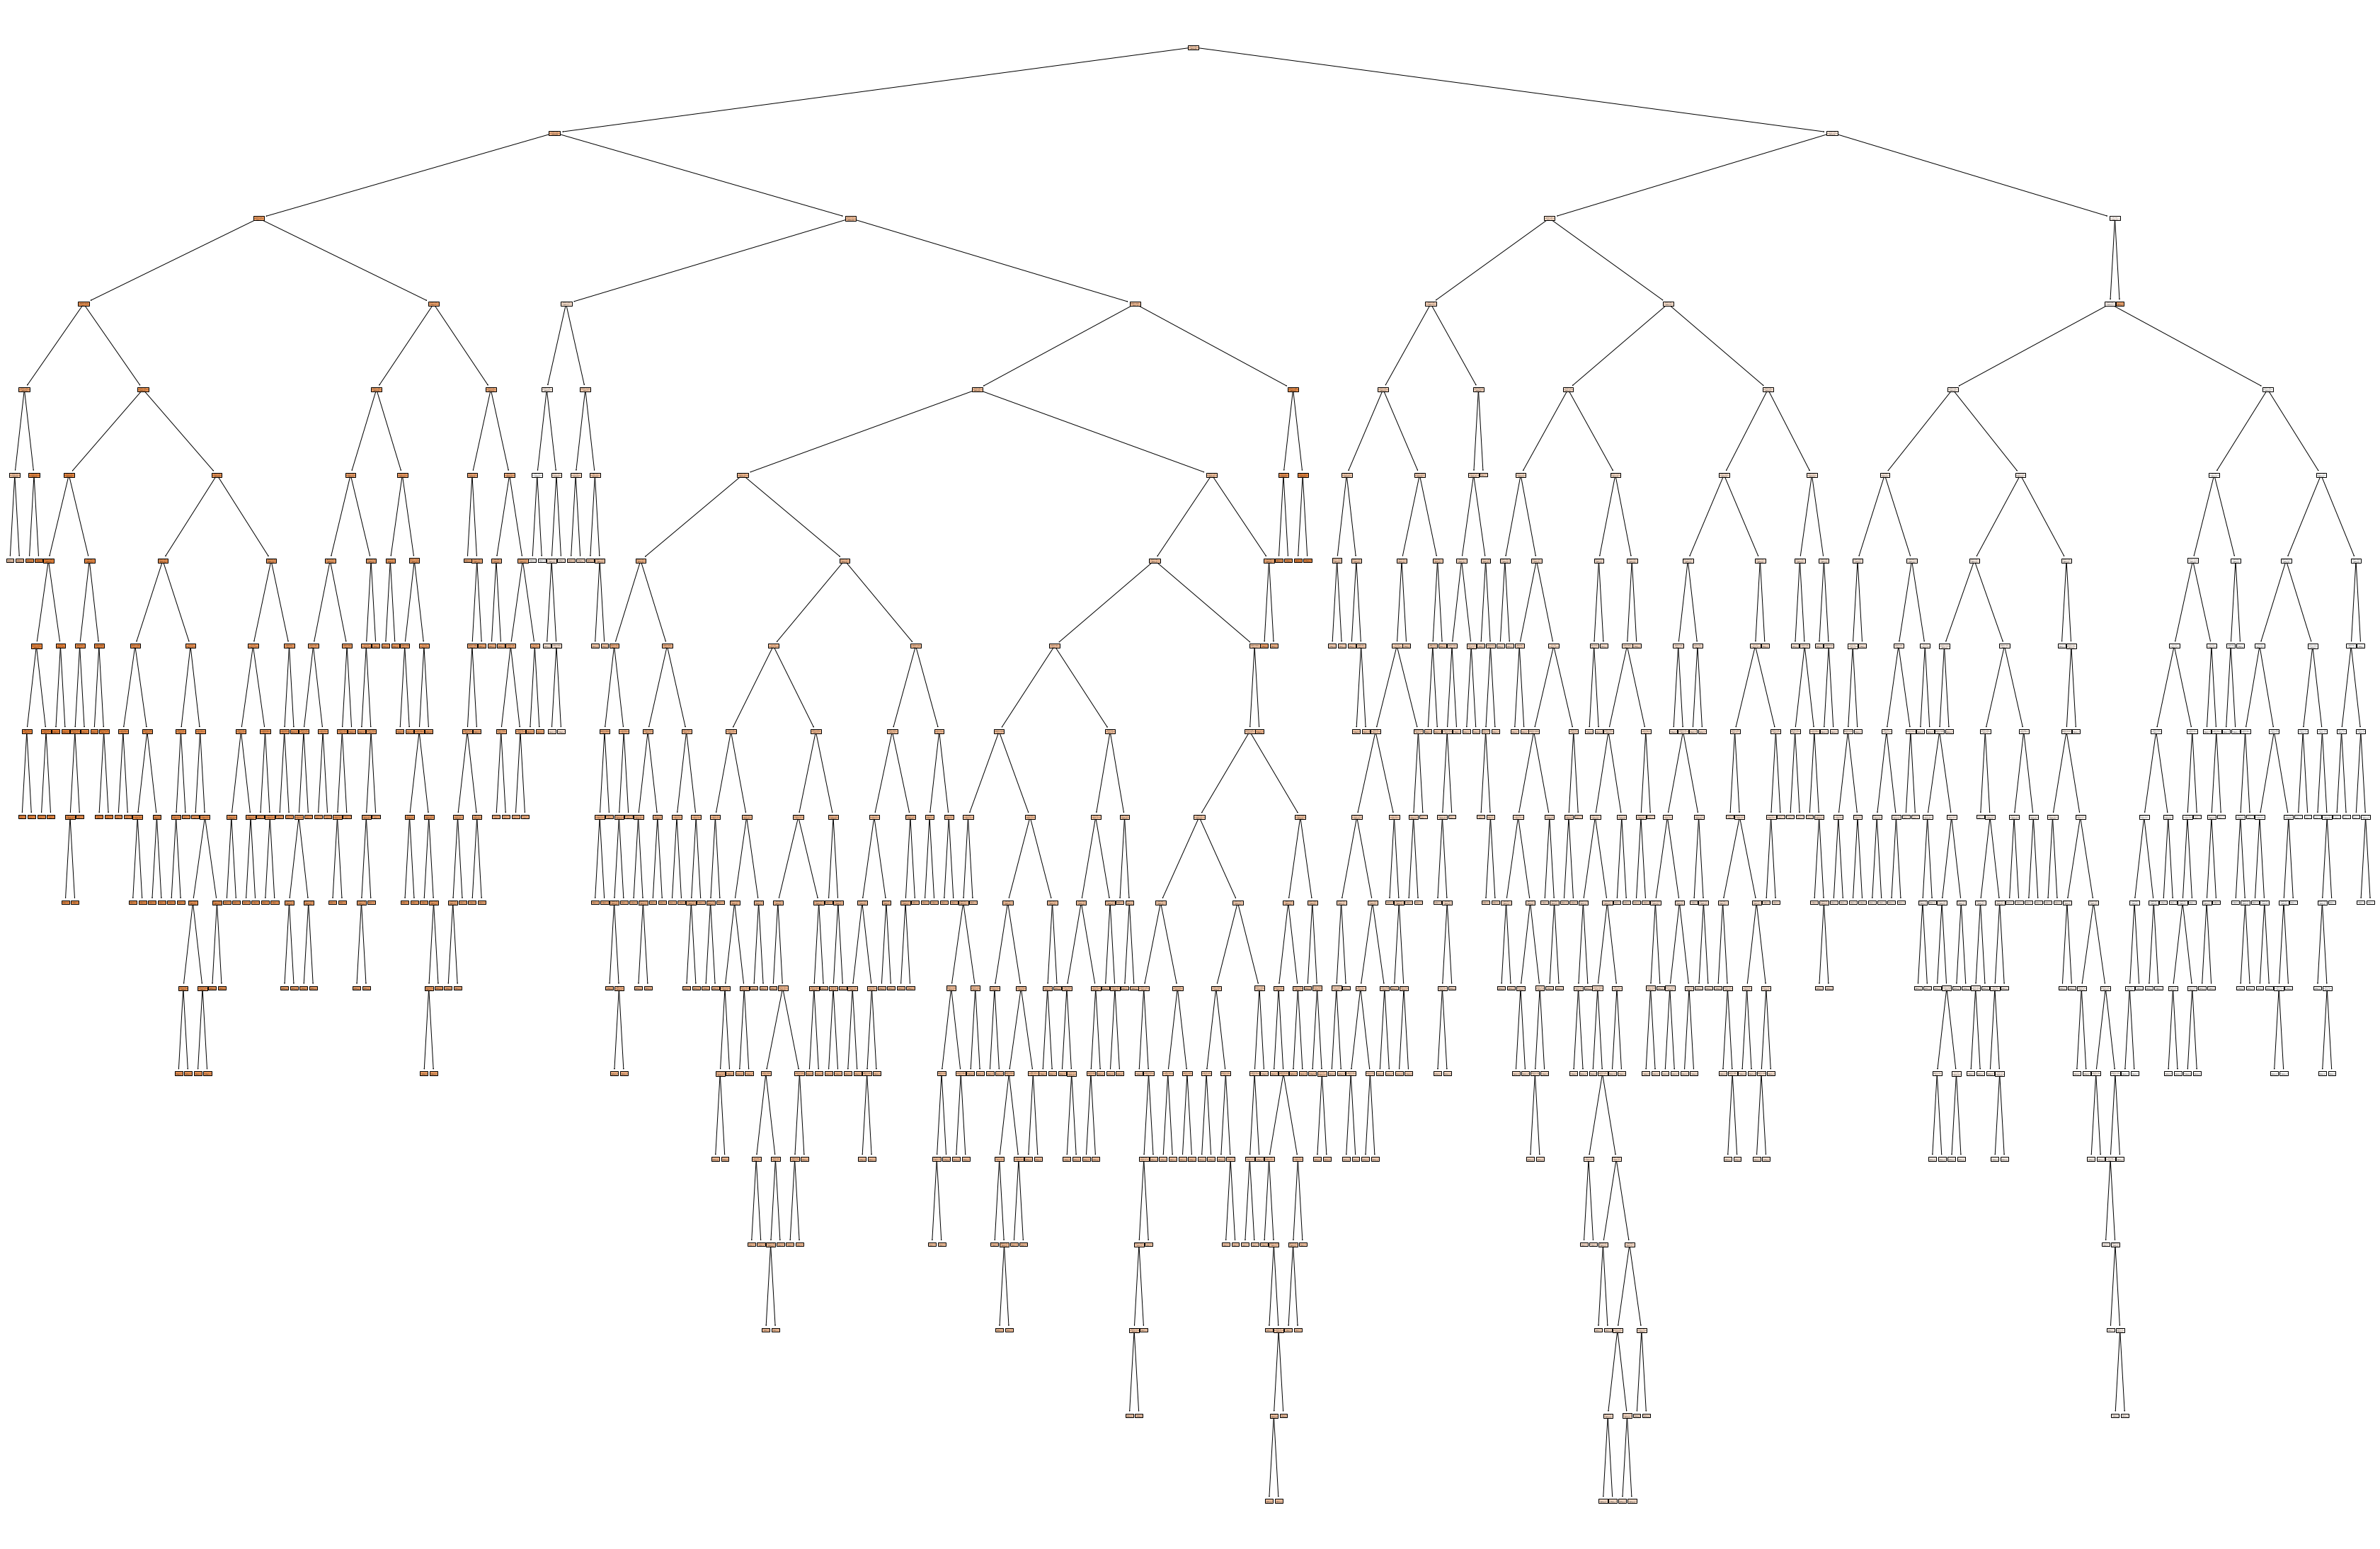

In [ ]:
fig = plt.figure(figsize=(60,40))
_ = tree.plot_tree(tree_model, 
                   feature_names=feature_names,  
                   filled=True)

## Random Forest

First, we need to split our data into train and test sets - 10% test and 90% train data. Then, we can build a random forest regression model (as the dependent CLV variable is continuous) using the train set (we will use it for grid search cross-validation) and measure its performance on the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data[y], test_size=0.1, random_state=42)

In [ ]:
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train['CLV'])
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.9633334090332589 {'max_depth': 8}


In [ ]:
y_pred = tree_model.predict(X_test)
y_pred_train = tree_model.predict(X_train)

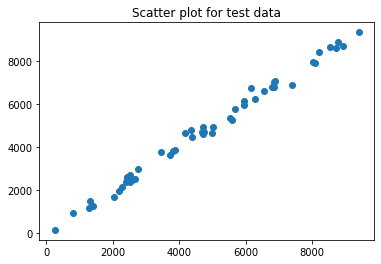

In [ ]:
plt.scatter(y_test, y_pred)
plt.title("Scatter plot for test data")
plt.show()

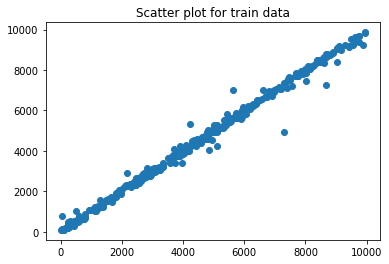

In [ ]:
plt.scatter(y_train, y_pred_train)
plt.title("Scatter plot for train data")
plt.show()

In [ ]:
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
mse = mean_squared_error(y_train, y_pred_train, squared=True)
mad = mean_absolute_error(y_train, y_pred_train)
print('Performance on train data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on train data:
The r2 is:  0.9933397681179884
The rmse is:  213.94623345953607
The mse is:  45772.99081152231
The mad is:  112.25966008773025


In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)
mad = mean_absolute_error(y_test, y_pred)
print('Performance on test data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on test data:
The r2 is:  0.9924665642881356
The rmse is:  209.49873768016238
The mse is:  43889.72108958149
The mad is:  162.07787853891713


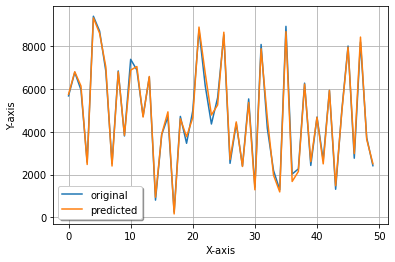

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

## XGBoost

First, we need to split our data into train and test sets - 20% test and 80% train data. Then, we can train an XGBoost regressor model using the train set and measure its performance on the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data[y], test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

[15:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


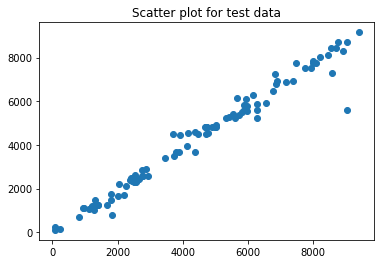

In [ ]:
plt.scatter(y_test, y_pred)
plt.title("Scatter plot for test data")
plt.show()

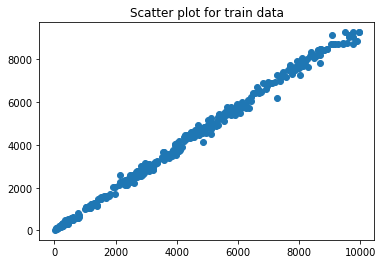

In [ ]:
plt.scatter(y_train, y_pred_train)
plt.title("Scatter plot for train data")
plt.show()

In [ ]:
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
mse = mean_squared_error(y_train, y_pred_train, squared=True)
mad = mean_absolute_error(y_train, y_pred_train)
print('Performance on train data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on train data:
The r2 is:  0.9912495837764593
The rmse is:  245.88471916470718
The mse is:  60459.29511870691
The mad is:  172.9250456376755


In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)
mad = mean_absolute_error(y_test, y_pred)
print('Performance on test data:')
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
print('The mse is: ', mse)
print('The mad is: ', mad)

Performance on test data:
The r2 is:  0.9633026563146142
The rmse is:  480.9594587153553
The mse is:  231322.00092776757
The mad is:  283.56351099787105
